In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# !pip install torch
# !pip install transformers
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from transformers import get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from torch.cuda.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup


from imblearn.over_sampling import SMOTE

In [10]:
# Step 1: Prepare the data
data = pd.read_csv('/content/drive/MyDrive/NLP Final Project/Unbalanced_data.csv.csv')
data = data.dropna()
X = data['description']
y = data['label']


# Create a TF-IDF vectorizer to convert text to numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Create an instance of the SMOTE algorithm
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to generate synthetic samples
X_balanced, y_balanced = smote.fit_resample(X, y)

# Convert X_balanced back to DataFrame with appropriate column names
balanced_data = pd.DataFrame(X_balanced.toarray(), columns=vectorizer.get_feature_names_out())

# Add the 'label_encoded' column to the DataFrame
balanced_data['label_encoded'] = y_balanced





In [11]:
balanced_data.head()

,10,100,104,107,11,1102,12,120,125,13,...,yielding,young,youngswick,zephyr,zimmer,zometa,zone,zones,zygomatic,label_encoded
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Allergy / Immunology
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Allergy / Immunology
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Allergy / Immunology
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Allergy / Immunology
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Allergy / Immunology


In [12]:
len(balanced_data)

44160

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/20 - Train Loss: 3.5005 - Train Accuracy: 0.1020
Epoch 1/20 - Test Loss: 1.7551 - Test Accuracy: 0.6344
Epoch 2/20 - Train Loss: 1.3651 - Train Accuracy: 0.7101
Epoch 2/20 - Test Loss: 0.4236 - Test Accuracy: 0.8945
Epoch 3/20 - Train Loss: 0.5209 - Train Accuracy: 0.8877
Epoch 3/20 - Test Loss: 0.2161 - Test Accuracy: 0.9361
Epoch 4/20 - Train Loss: 0.3217 - Train Accuracy: 0.9210
Epoch 4/20 - Test Loss: 0.1729 - Test Accuracy: 0.9507
Epoch 5/20 - Train Loss: 0.2430 - Train Accuracy: 0.9361
Epoch 5/20 - Test Loss: 0.3687 - Test Accuracy: 0.8989
Epoch 6/20 - Train Loss: 0.1920 - Train Accuracy: 0.9447
Epoch 6/20 - Test Loss: 0.1253 - Test Accuracy: 0.9590
Epoch 7/20 - Train Loss: 0.1447 - Train Accuracy: 0.9565
Epoch 7/20 - Test Loss: 0.0985 - Test Accuracy: 0.9681
Epoch 8/20 - Train Loss: 0.1208 - Train Accuracy: 0.9636
Epoch 8/20 - Test Loss: 0.0938 - Test Accuracy: 0.9675
Epoch 9/20 - Train Loss: 0.1013 - Train Accuracy: 0.9698
Epoch 9/20 - Test Loss: 0.0761 - Test Accuracy:

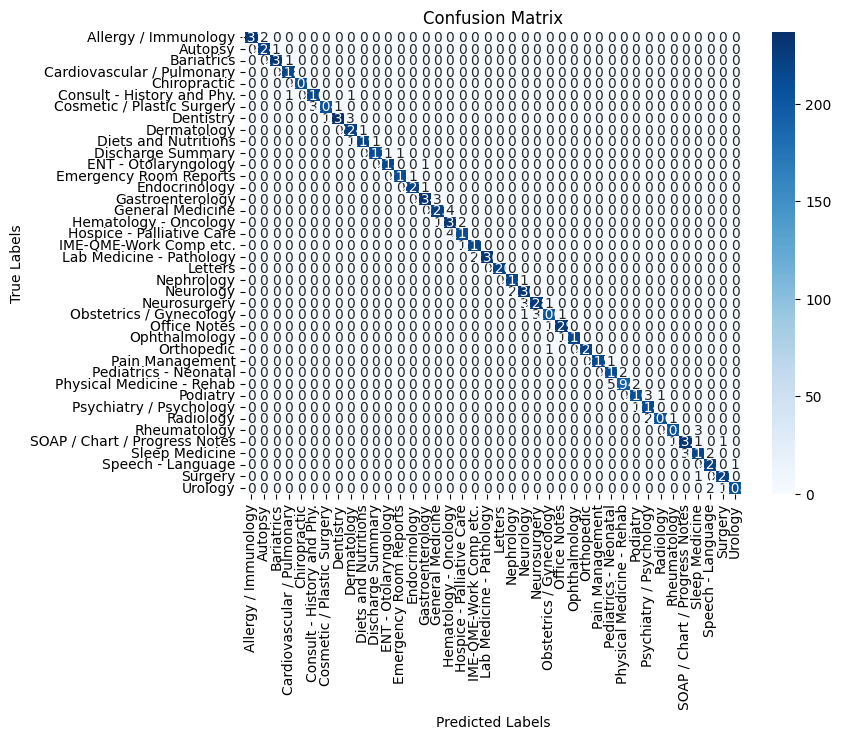

In [13]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data.drop('label_encoded', axis=1), balanced_data['label_encoded'], test_size=0.2, random_state=42)

# Step 3: Fine-tune the Bert model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(data['label'].unique()))
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
# Tokenize and prepare data
train_texts = X_train.apply(lambda x: ' '.join(str(x).split()[:256]), axis=1)
test_texts = X_test.apply(lambda x: ' '.join(str(x).split()[:256]), axis=1)

train_encodings = tokenizer.batch_encode_plus(train_texts.tolist(), truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer.batch_encode_plus(test_texts.tolist(), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Use LabelEncoder to convert labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert the input data to tensors
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))

# Define batch size and create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20

train_accuracy_list = []
train_loss_list = []
test_loss_list = []
test_accuracy_list = []
epoch_list = []  # List of epochs from 1 to 20

# Learning rate scheduler
gradient_accumulation_steps = 4
total_steps = len(train_loader) * num_epochs // gradient_accumulation_steps
warmup_steps = int(0.1 * total_steps)  # warmup for the first 10% of total steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Initialize variables for early stopping
best_test_accuracy = 0.0
patience = 5
no_improvement_count = 0

tokenizer.save_pretrained('/content/drive/MyDrive/NLP Final Project/XLNET_TOKENIZER')

# Create the directory for model weights if it does not exist
model_directory = '/content/drive/MyDrive/NLP Final Project/XLNET_WEIGHTS'
os.makedirs(model_directory, exist_ok=True)

# Measure training time
start_time = time.time()


# Gradient scaler for mixed precision training
scaler = GradScaler()


for epoch in range(num_epochs):
    epoch_list.append(epoch + 1)
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for step, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        train_loss += loss.item()
        _, predicted_labels = torch.max(outputs.logits, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

    # Calculate validation accuracy
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()

            _, predicted_labels = torch.max(outputs.logits, 1)
            test_correct += (predicted_labels == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

    # Check for early stopping condition
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        no_improvement_count = 0
        # Save the model weights and optimizer state dictionary for the best accuracy
        model_path = f'/content/drive/MyDrive/NLP Final Project/XLNET_WEIGHTS/best_model.pt'
        torch.save(model.state_dict(), model_path)
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break


end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Calculate precision, recall, and F1 score
model.eval()
all_predictions = []
all_labels = []

# Measure prediction time
start_time = time.time()

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction Time: {prediction_time:.2f} seconds")

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



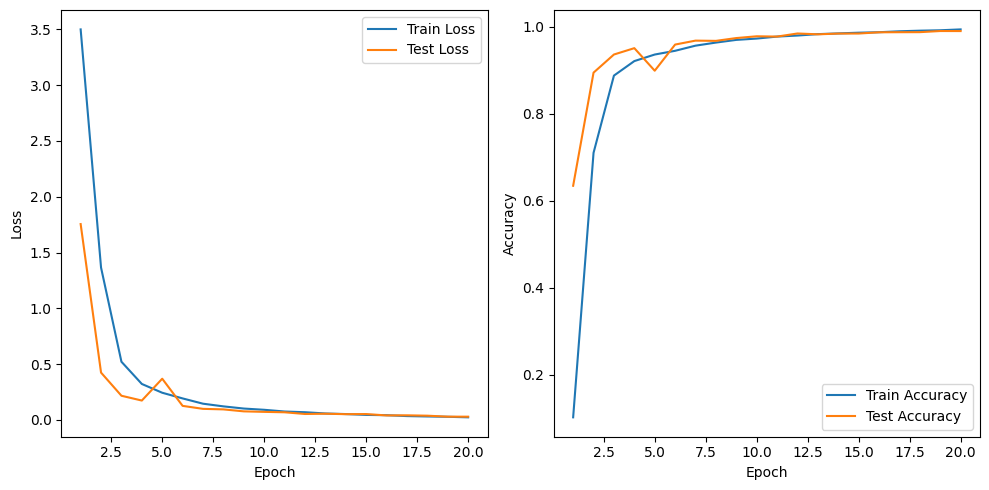

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the plots to a specific directory
plots_dir = '/content/drive/MyDrive/NLP Final Project/PLOTS'
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, 'xlnet_loss_and_accuracy_curves.png'))
plt.show()